# Lab 6

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
 
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.backend import argmax
 
 
model = VGG16(weights='imagenet', include_top=True) #Load alredy pre-trained model
model.summary() #Print a list of layers with all the details

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Intro

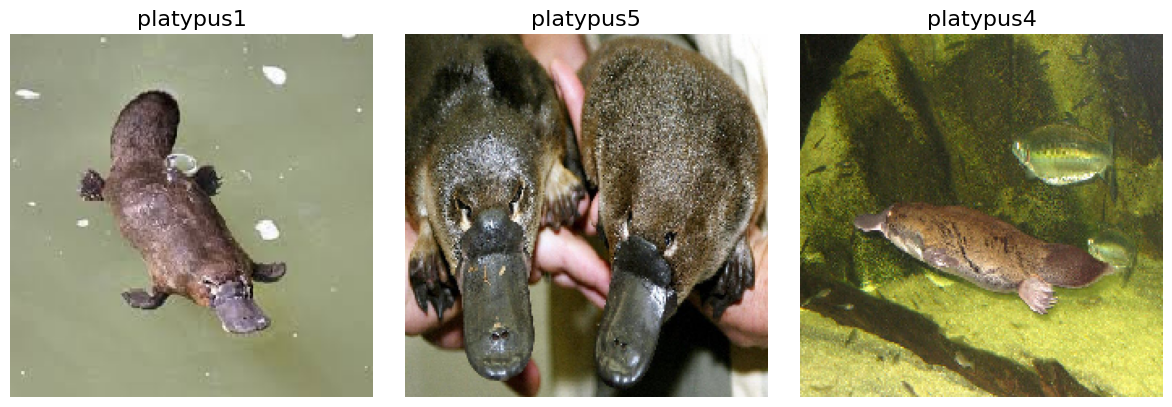

In [44]:
#Further on, each time you will need to complete the code, it will be marked by #TODO
 
# Assign image titles for your images
image_titles = ['platypus1', 'platypus5', 'platypus4']

dir = "/home/karolina/Documents/ML-ISS/lab6/pictures/"
 
# Load images and reshape them
img1 = load_img(dir+'platypus1.jpeg', target_size=(224, 224))
img2 = load_img(dir+'platypus5.jpg', target_size=(224, 224))
img3 = load_img(dir+'platypus4.jpg', target_size=(224, 224))
#We resize the images into size 224 x 224, as the model prefers those sizes. However, if your images are smaller, you can change those values a little bit.
 
# Convert them to a Numpy array
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])
 
# Preparing input data for VGG16
X = preprocess_input(images)
 
# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [45]:
# Predict the output (probabilities) of the layer, corresponding to an image
preds = model.predict(X)
best_class = argmax(preds)
 
print('Predicted for image 1:', decode_predictions(preds, top=3)[0])
print('Predicted for image 2:', decode_predictions(preds, top=3)[1])
print('Predicted for image 3:', decode_predictions(preds, top=3)[2])
#Decode prediction based on Imagenet dataset dictionary. Each umerical class is assigned to a real-life label

1/1 [==============================] - 0s 115ms/step
Predicted for image 1: [('n01873310', 'platypus', 0.9999651), ('n02363005', 'beaver', 1.9907353e-05), ('n01667778', 'terrapin', 4.663599e-06)]
Predicted for image 2: [('n01873310', 'platypus', 0.99999833), ('n02174001', 'rhinoceros_beetle', 1.521824e-06), ('n02177972', 'weevil', 7.1232876e-08)]
Predicted for image 3: [('n01873310', 'platypus', 0.9937856), ('n01632777', 'axolotl', 0.0056233774), ('n02640242', 'sturgeon', 0.00018766716)]


## Heatmaps

In [6]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

In [22]:
def visualise_heatmap(map, image):
  f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
  for i, title in enumerate(image_titles):
      heatmap = np.uint8(cm.jet(map[i])[..., :3] * 255)
      ax[i].set_title(title, fontsize=16)
      ax[i].imshow(images[i])
      ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
      ax[i].axis('off')
  plt.tight_layout()
  plt.show()

### GradCam

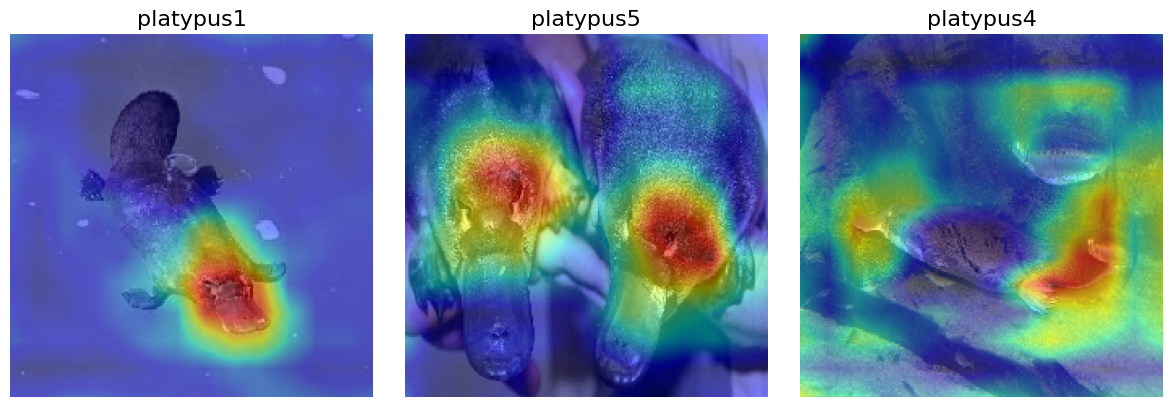

In [46]:
replace2linear = ReplaceToLinear()
best_class = argmax(preds)
score = CategoricalScore(list(best_class))
 
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)
 
cam = gradcam(score,
              X,
              penultimate_layer=-1)
 
visualise_heatmap(cam, img1)

### GradCam++

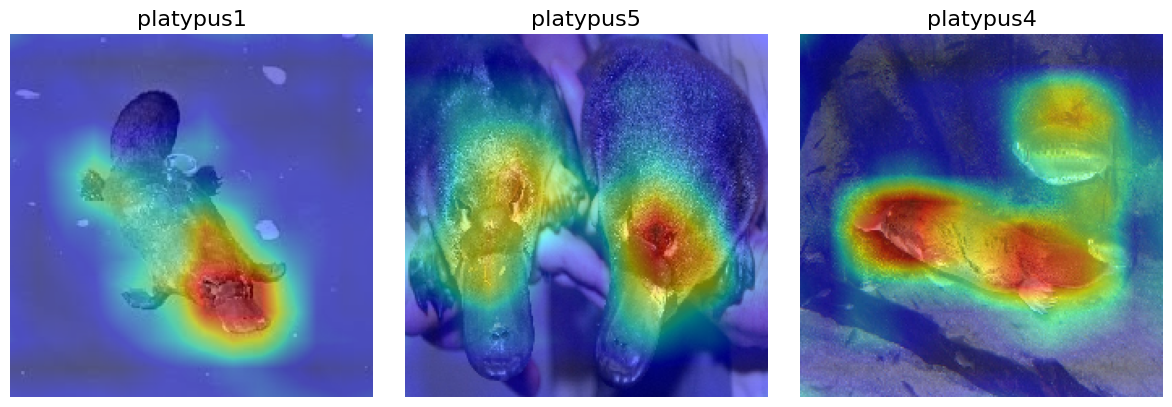

In [47]:
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)
 
cam = gradcam(score,
              X,
              penultimate_layer=-1)
 
visualise_heatmap(cam,img1)

### ScoreCAM

48/48 [==============================] - 39s 814ms/step


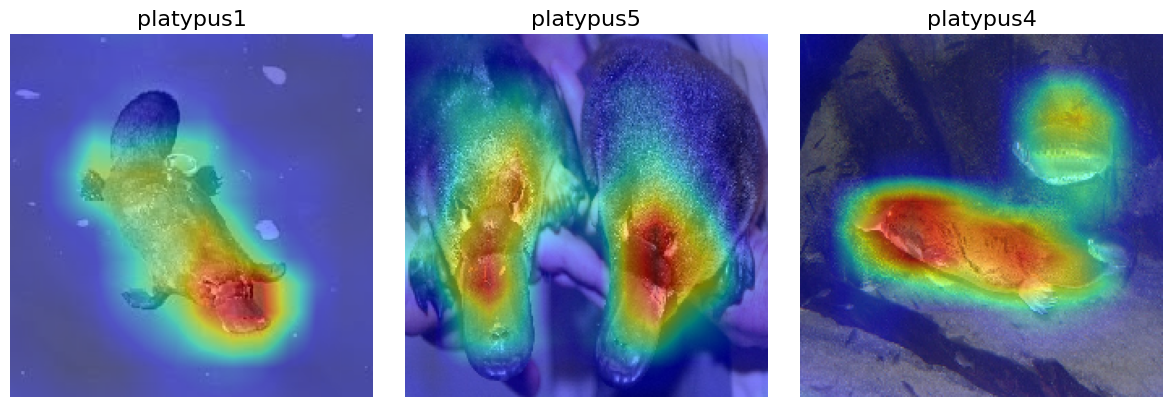

In [48]:
scorecam = Scorecam(model)
cam = scorecam(score, X, penultimate_layer=-1)
visualise_heatmap(cam,img1)

### SaliencyMaps

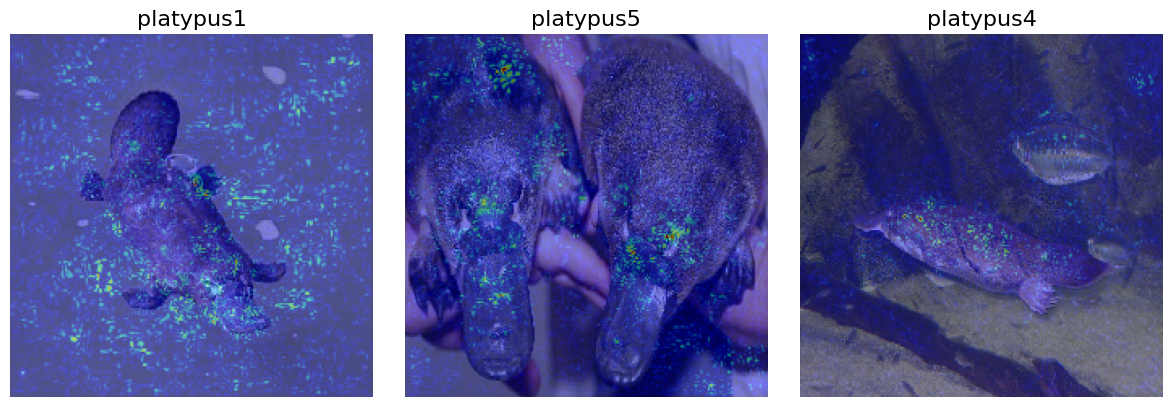

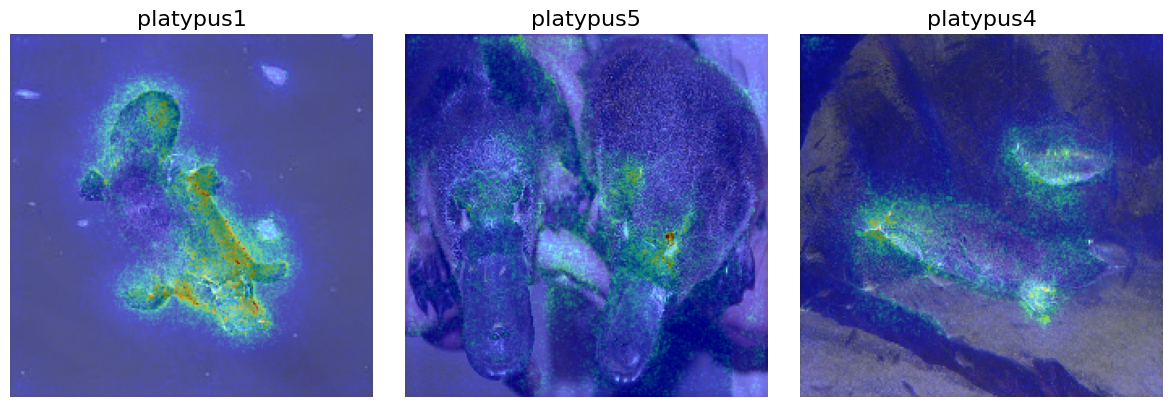

In [49]:
saliency = Saliency(model, model_modifier=replace2linear, clone=True)
saliency_map = saliency(score, X)
visualise_heatmap(saliency_map, img1)
saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)
visualise_heatmap(saliency_map,img1)

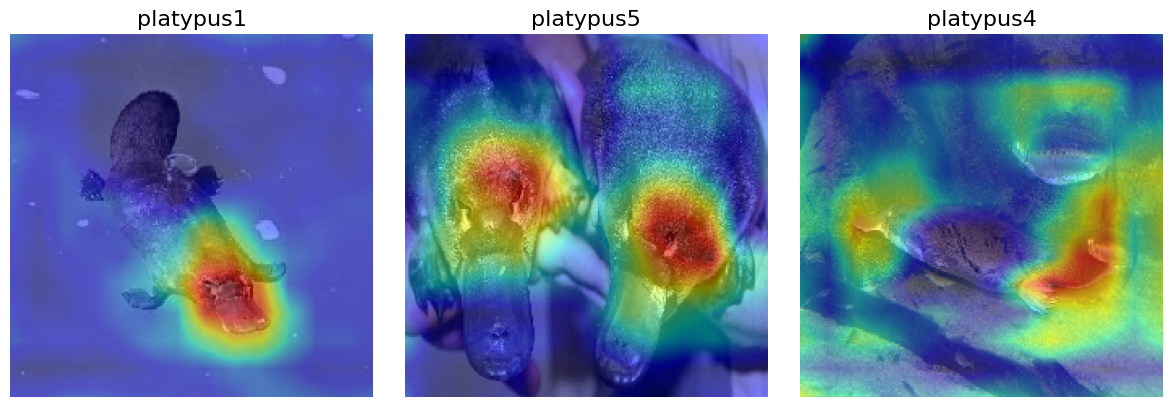

In [51]:
from tensorflow import argsort

replace2linear = ReplaceToLinear()
best_class = argsort(preds)[:,-1]
score = CategoricalScore(list(best_class))
 
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)
 
cam = gradcam(score,
              X,
              penultimate_layer=-1)
 
visualise_heatmap(cam, img1)

## Visualizing Intermediate Activations

1/1 [==============================] - 0s 130ms/step


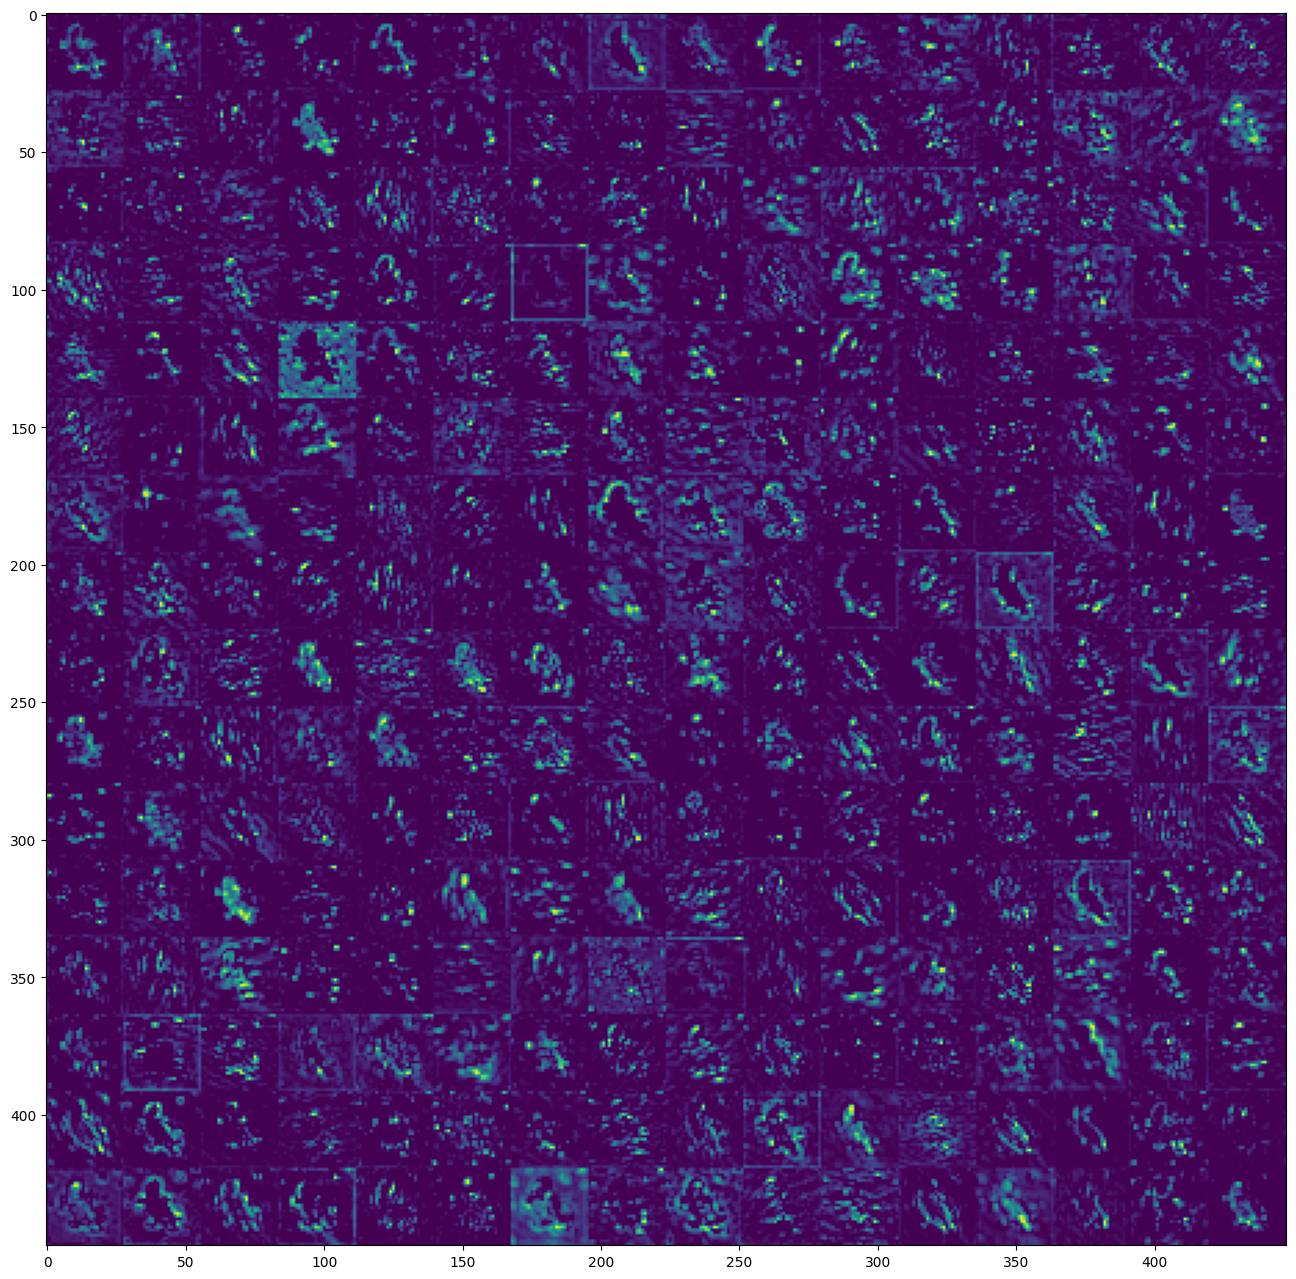

In [60]:
layer_outputs = [layer.output for layer in model.layers] #Loop through the model defined in the beginning to access outputs of individual layers
activation_model = models.Model(model.input, layer_outputs)
X_reshaped = np.expand_dims(X[0], 0)
activations = activation_model.predict(X_reshaped)
 
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name == 'block3_pool':
        number_of_feature_maps = layer_activation.shape[-1]
        feature_map_shape = layer_activation.shape[1]
        n_cols = number_of_feature_maps // images_per_row
        display_grid = np.zeros((feature_map_shape * n_cols, images_per_row * feature_map_shape))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image /= np.max(channel_image)
                display_grid[col * feature_map_shape : (col + 1) * feature_map_shape, row * feature_map_shape : (row + 1) * feature_map_shape] = channel_image
        scale = 1. / feature_map_shape
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.imshow(display_grid, aspect='auto', cmap='viridis')